# Description

Adjustments:<br>
- 0.1 insert name of you utilities folder<br>
- 0.3 insert name of  dataset<br>
-

In [ ]:
original_structure = True

root_dir_data = "/Volumes/AG_Couzin-Fuchs/DATA/experiment_trackball_Optomotor/locustVR"

flip_symmetric_control = False

save_pickle = True
save_path = "/Users/aljoscha/Downloads"

## 0. Initialisation

In [48]:
%reload_ext autoreload
%autoreload 2

### 0.1 Set util directory

##### Change to match directory of utilities

In [49]:
utilities_name = "utilities-main"
sub_dir = None
in_unitydataanalysis = True
unitydataanalysis_name = "UnityDataAnalysis-main"

def access_utilities(utilities_name='utilities' , sub_dir=None, in_unitydataanalysis=True, unitydataanalysis_name='UnityDataAnalysis'):
    from pathlib import Path
    import sys
    cwd = Path.cwd()
    parent_dir = cwd.resolve().parents[0]
    # print(parent_dir)
    if sub_dir is not None:
        path_utilities = Path(parent_dir) / sub_dir / utilities_name
        sys.path.insert(0, str(path_utilities))
        print(path_utilities)
    else:
        path_utilities = Path(parent_dir) / utilities_name
        sys.path.insert(0, str(path_utilities))
        print(path_utilities)
    # sys.path.insert(0, str(Path(parent_dir) / "VTK_LocustVR/utilities-main"))
    if not in_unitydataanalysis:
        print(str(Path(parent_dir) / sub_dir / unitydataanalysis_name))
        sys.path.insert(1, str(Path(parent_dir) / "VTK_LocustVR/UnityDataAnalysis-main"))

access_utilities(utilities_name, sub_dir, in_unitydataanalysis, unitydataanalysis_name)
# access_utilities()

/Users/aljoscha/PycharmProjects/VTK_LocustVR/utilities-main


In [50]:
import os,json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
from useful_tools import select_animals_gpt,find_file,column_name_list,get_fill_between_range,read_seq_config
from data_cleaning import findLongestConseqSubseq,interp_fill

In [51]:
json_file = "./analysis_methods_dictionary.json"
with open(json_file, "r") as f:
    analysis_methods = json.loads(f.read())
    
thisDataset =root_dir_data
variable_name='location'
exp_name=analysis_methods.get("experiment_name")

## 1. Data preparation (only necessary for new datasets)

In [52]:
# Define the path to your Excel file
dir_list = []
file_type=".h5"
using_google_sheet=True
exp_name=analysis_methods.get("experiment_name")
if exp_name=='locustvr':
    sheet_name = 'LocustVR'
# if type(thisDataset) == str:
#     thisDataset = Path(thisDataset)
if analysis_methods.get("load_individual_data") == True:
    if using_google_sheet==True:
        # database_id = "1UL4eEUrQMapx9xz11-IyOSlPBcep3I9vBJ2uGgVudb8"
        #         #https://docs.google.com/spreadsheets/d/1UL4eEUrQMapx9xz11-IyOSlPBcep3I9vBJ2uGgVudb8/edit?usp=sharing
        # url = f"https://docs.google.com/spreadsheets/d/{database_id}/gviz/tq?tqx=out:csv&sheet={sheet_name}"
        database_id = "1UL4eEUrQMapx9xz11-IyOSlPBcep1I9vBJ2uGgVudb8"
                #https://docs.google.com/spreadsheets/d/1UL4eEUrQMapx9xz11-IyOSlPBcep1I9vBJ2uGgVudb8/edit?usp=sharing
        url = f"https://docs.google.com/spreadsheets/d/{database_id}/gviz/tq?tqx=out:csv&sheet={sheet_name}"
        #df = pd.read_excel(url, engine='openpyxl')## use this function if the file is not google sheet but uploaded excel file
        df = pd.read_csv(url)
    else:
        excel_file_path = "Z:/DATA/experiment_trackball_Optomotor/Locusts Management.xlsx"
        print(f"using a database {excel_file_path} from the server but this file might be outdated")
        # Create a 'with' statement to open and read the Excel file
        with pd.ExcelFile(excel_file_path) as xls:
            # Read the Excel sheet into a DataFrame with the sheet name (folder name)
            df = pd.read_excel(xls, sheet_name)
        ##list up the conditions and answers as strings for input argument to select animal. One condition must pair with one answer
    if analysis_methods.get("select_animals_by_condition") == True:
        animal_of_interest=select_animals_gpt(df,"Excluding this animal from analysis (Usually when animals die or molt, T/F)","F")
    else:
        animal_of_interest=df

    ID_array=animal_of_interest["ID"].values
    print(f"Valid animals IDs: \n {ID_array}")
    dir_list = [
    root.replace("\\", "/")
    for root, _, files in os.walk(thisDataset)
    if any(ID in root for ID in ID_array)
    and any(file.endswith(file_type) for file in files)]
else:
    for root, dirs, files in os.walk(thisDataset):
        for folder in dirs:
            folder_path=os.path.join(root,folder)
            if any(name.endswith(file_type) for name in os.listdir(folder_path)):
                dir_list.append(folder_path.replace("\\", "/"))

print("Directories:")
for i in dir_list:
    print(i)

Valid animals IDs: 
 ['GN25001' 'GN25002' 'GN25003' 'GN25004' 'GN25006' 'GN25007' 'GN25008'
 'GN25009' 'GN25011' 'GN25012' 'GN25013' 'GN25014' 'GN25015' 'GN25016'
 'GN25017' 'GN25018' 'GN25020' 'GN25021']
Directories:
/Volumes/AG_Couzin-Fuchs/DATA/experiment_trackball_Optomotor/locustVR/GN25001/20250624/choices/session1
/Volumes/AG_Couzin-Fuchs/DATA/experiment_trackball_Optomotor/locustVR/GN25002/20250624/choices/session1
/Volumes/AG_Couzin-Fuchs/DATA/experiment_trackball_Optomotor/locustVR/GN25003/20250624/choices/session1
/Volumes/AG_Couzin-Fuchs/DATA/experiment_trackball_Optomotor/locustVR/GN25004/20250624/choices/session1
/Volumes/AG_Couzin-Fuchs/DATA/experiment_trackball_Optomotor/locustVR/GN25006/20250625/choices/session1
/Volumes/AG_Couzin-Fuchs/DATA/experiment_trackball_Optomotor/locustVR/GN25007/20250625/choices/session1
/Volumes/AG_Couzin-Fuchs/DATA/experiment_trackball_Optomotor/locustVR/GN25008/20250625/choices/session1
/Volumes/AG_Couzin-Fuchs/DATA/experiment_trackball_Opt

### 1.2 Define functions for heading alignment and reindexing time

In [53]:
def align_and_flip_heading(df, heading_col='heading', trial_col='trial_id', t_col='ts', state_col='state_type'):
    df = df.copy()

    # 1. Normalize heading relative to the first frame (t == 0) of each trial
    trial_starts = df[df[t_col] == 0].set_index(trial_col)[heading_col]
    df['heading_rel'] = df[heading_col] - df[trial_col].map(trial_starts)

    # 2. Wrap to [-π, π)
    df['heading_rel'] = (df['heading_rel'] + np.pi) % (2 * np.pi) - np.pi

    # 3. Create flipped version (only flipped for state_type == 2)
    df['heading_rel_flip'] = df['heading_rel']
    flip_mask = df[state_col] == 2
    df.loc[flip_mask, 'heading_rel_flip'] = -df.loc[flip_mask, 'heading_rel_flip']

    return df

def reindex_t_by_state_transition(df, transition_from=0, transition_to=(1, 2), index_col='ts', state_col='state_type'):
    df = df.copy()
    state = df[state_col].to_numpy()

    # Step 1: Detect valid transitions from 0 → 1 or 2
    prev = np.roll(state, 1)
    prev[0] = transition_from
    is_transition = (prev == transition_from) & np.isin(state, transition_to)

    # Step 2: Mark all positions as belonging to a segment
    group_id = np.zeros_like(state, dtype=int)
    group_id[:] = -1  # init with -1 (unassigned)
    current_group = 0

    t = np.full_like(state, np.nan, dtype=float)

    for idx in np.flatnonzero(is_transition):
        # Walk backward while state == transition_from
        i = idx - 1
        while i >= 0 and state[i] == transition_from and group_id[i] == -1:
            group_id[i] = current_group
            i -= 1

        # Assign transition point and forward as long as state remains in transition_to
        i = idx
        while i < len(state) and state[i] in transition_to and group_id[i] == -1:
            group_id[i] = current_group
            i += 1

        current_group += 1

    # Step 3: Assign relative t values within each group
    df['group'] = group_id
    for g in range(current_group):
        segment = df[df['group'] == g]
        idxs = segment.index.to_numpy()

        # Find first transition point (t=0)
        transition_idx = idxs[np.isin(state[idxs], transition_to)][0]
        df.loc[idxs, index_col] = idxs - transition_idx

    df.drop(columns='group', inplace=True)
    df[index_col] = df[index_col].astype('Int64')
    return df

### 1.3 Read data and apply changes

In [54]:
file_name = f"XY_full.h5"
pd_list = []
for index, this_dir in enumerate(dir_list):
    print(index, this_dir)
    this_pd = pd.read_hdf(os.path.join(this_dir, file_name))
    this_pd['animal_id'] = index
    this_pd = reindex_t_by_state_transition(this_pd, transition_from=0, transition_to=(1, 2))
    this_pd = align_and_flip_heading(this_pd)
    pd_list.append(this_pd)

df=pd.concat(pd_list,ignore_index=True)

if save_pickle:
    df.to_pickle(os.path.join(save_path, 'locustvr_data.pkl'))

0 /Volumes/AG_Couzin-Fuchs/DATA/experiment_trackball_Optomotor/locustVR/GN25001/20250624/choices/session1
1 /Volumes/AG_Couzin-Fuchs/DATA/experiment_trackball_Optomotor/locustVR/GN25002/20250624/choices/session1
2 /Volumes/AG_Couzin-Fuchs/DATA/experiment_trackball_Optomotor/locustVR/GN25003/20250624/choices/session1
3 /Volumes/AG_Couzin-Fuchs/DATA/experiment_trackball_Optomotor/locustVR/GN25004/20250624/choices/session1
4 /Volumes/AG_Couzin-Fuchs/DATA/experiment_trackball_Optomotor/locustVR/GN25006/20250625/choices/session1
5 /Volumes/AG_Couzin-Fuchs/DATA/experiment_trackball_Optomotor/locustVR/GN25007/20250625/choices/session1
6 /Volumes/AG_Couzin-Fuchs/DATA/experiment_trackball_Optomotor/locustVR/GN25008/20250625/choices/session1
7 /Volumes/AG_Couzin-Fuchs/DATA/experiment_trackball_Optomotor/locustVR/GN25009/20250625/choices/session1
8 /Volumes/AG_Couzin-Fuchs/DATA/experiment_trackball_Optomotor/locustVR/GN25011/20250625/choices/session1
9 /Volumes/AG_Couzin-Fuchs/DATA/experiment_tra

### 1.4 Concat data and save

## 2. Load data

##### Change path to save

In [56]:
df = pd.read_pickle(os.path.join(save_path, 'locustvr_data.pkl'))

### 2.1 Check format

In [57]:
print(df)
print(df['ts'].min(), df['ts'].max())
print(df['ts'].value_counts()[df['ts'].max()])

                X          Y   heading     ts  trial_id  state_type  \
0       -0.004847  -0.001845  1.378215  -9408         0           0   
1       -0.013489  -0.026297  1.335805  -9407         0           0   
2       -0.021833  -0.050318  1.335805  -9406         0           0   
3       -0.029885  -0.073905  1.408251  -9405         0           0   
4       -0.037650  -0.097059  1.408251  -9404         0           0   
...           ...        ...       ...    ...       ...         ...   
5707857  4.818589 -35.891693  1.893089   2873        18           1   
5707858  4.821211 -35.897220  1.843491   2874        18           1   
5707859  4.823629 -35.902826  1.843491   2875        18           1   
5707860  4.825835 -35.908510  1.843491   2876        18           1   
5707861  4.827820 -35.914269  1.843491   2877        18           1   

         animal_id  heading_rel  heading_rel_flip  
0                0     0.949213          0.949213  
1                0     0.906803          0.

## 3. Visualisation

In [58]:
angle_version = "heading_rel" # Options: 'heading_rel', 'heading_rel_flip'

### 3.1 Angle over time (select what to plot)

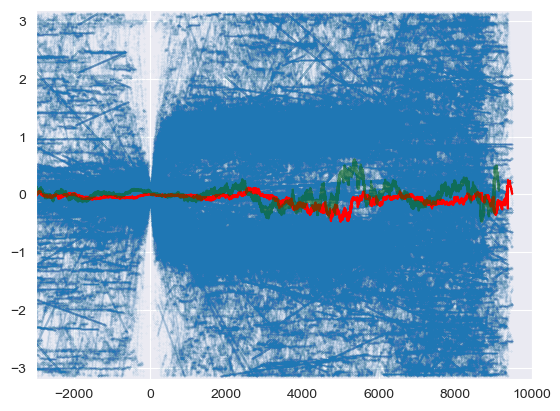

In [59]:
select = ["data", "angle", "angular_velocity"]  # Options: 'data', 'angle', 'angular_velocity'

# data
fig, ax = plt.subplots()
if "data" in select:
    # plt.scatter(df['ts'], df['heading_rel'], label='t', s=0.04, alpha=0.006)
    ax.scatter(df['ts'], df[angle_version], label='t', s=0.05, alpha=0.05)

# angle
# df_mean = df.groupby('ts', as_index=False)['heading_rel'].mean()
df_mean = df.groupby('ts', as_index=False)[angle_version].median()
if "angle" in select:
    ax.plot(df_mean['ts'], df_mean[angle_version], color='red', label='mean heading')

# df_mean = df_mean.sort_values('ts')
# df_mean['heading_smooth'] = df_mean['heading_rel'].rolling(window=900, center=True).mean()
# df_mean['angular_velocity'] = df_mean['heading_smooth'].diff() / df_mean['ts'].diff()
# df_mean = df_mean.dropna(subset=['angular_velocity'])
# plt.plot(df_mean['ts'], df_mean['angular_velocity']*1500, color='purple', alpha=0.5)

# angular_velocity
df_median = df.groupby('ts', as_index=False)[angle_version].median()
df_median = df_median.sort_values('ts')
df_median['heading_smooth'] = df_median[angle_version].rolling(window=700, center=True).mean()
df_median['angular_velocity'] = df_median['heading_smooth'].diff() / df_median['ts'].diff()
df_median = df_median.dropna(subset=['angular_velocity'])
if "angular_velocity" in select:
    ax.plot(df_median['ts'], df_median['angular_velocity']*1000, color='darkgreen', alpha=0.5)

plt.xlim(-3000, 10000)
plt.ylim(-3.2, 3.2)
plt.show()

### 3.2 Desity of angles (for time bins)

#### 3.2.1 Histogram

In [60]:
angle_bins = np.linspace(-np.pi, np.pi, 360)  # 1° bins
critical_time = [-2000, 0, 1000, 2000, 6000, 10000]

time_windows = {}
for i in range(len(critical_time)-1):
    row = {f"t1 ({critical_time[i]} to {critical_time[i+1]})": (critical_time[i], critical_time[i+1]),}
    time_windows.update(row)

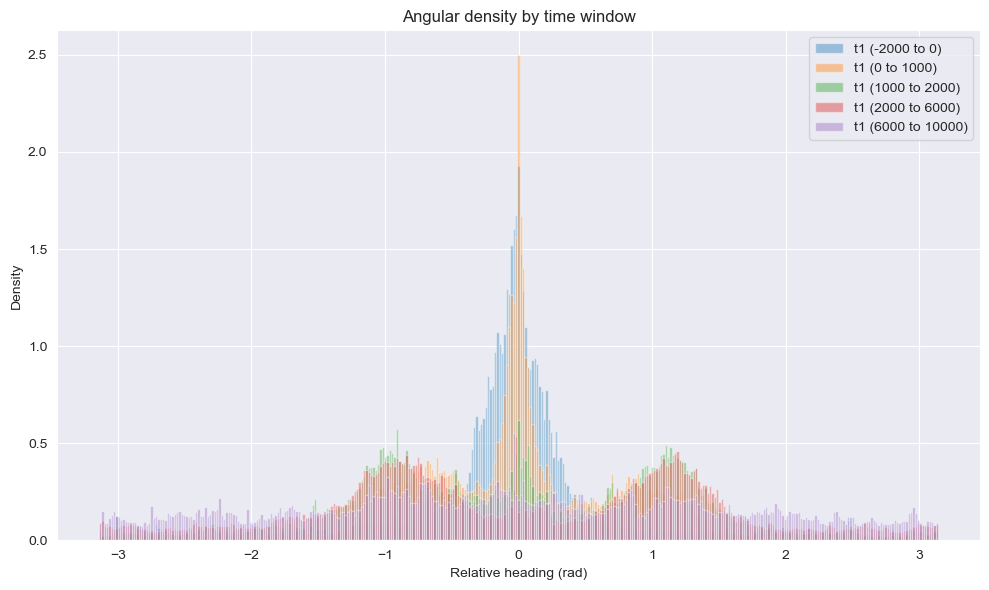

In [61]:
plt.figure(figsize=(10, 6))

for label, (t_start, t_end) in time_windows.items():
    mask = (df['ts'] >= t_start) & (df['ts'] < t_end)
    angles = df.loc[mask, angle_version]

    plt.hist(angles, bins=angle_bins, density=True, alpha=0.4, label=label)

plt.xlabel('Relative heading (rad)')
plt.ylabel('Density')
plt.title('Angular density by time window')
plt.legend()
plt.tight_layout()
plt.show()

#### 3.2.2 Kernel Density Estimation (KDE)

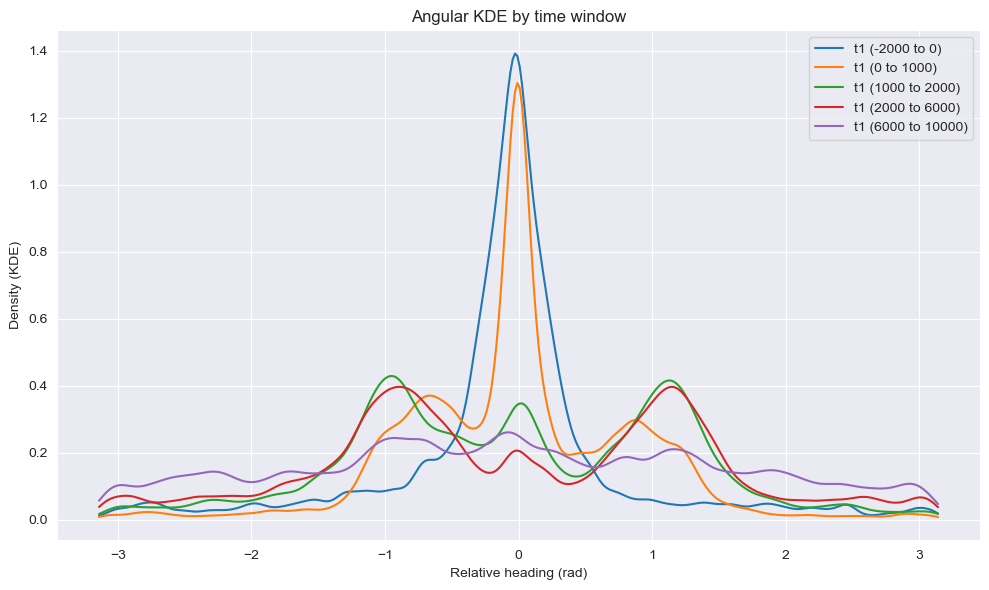

In [62]:
plt.figure(figsize=(10, 6))

for label, (t_start, t_end) in time_windows.items():
    mask = (df['ts'] >= t_start) & (df['ts'] < t_end)
    angles = df.loc[mask, angle_version].dropna()

    if len(angles) < 5:
        continue  # Skip very small samples to avoid noisy KDEs

    # Fit KDE
    kde = gaussian_kde(angles, bw_method='scott')  # 'scott' or 'silverman'
    kde_values = kde(angle_bins)

    plt.plot(angle_bins, kde_values, label=label)

plt.xlabel('Relative heading (rad)')
plt.ylabel('Density (KDE)')
plt.title('Angular KDE by time window')
plt.legend()
plt.tight_layout()
plt.show()

### 3.3 Trajectories (preliminary!)

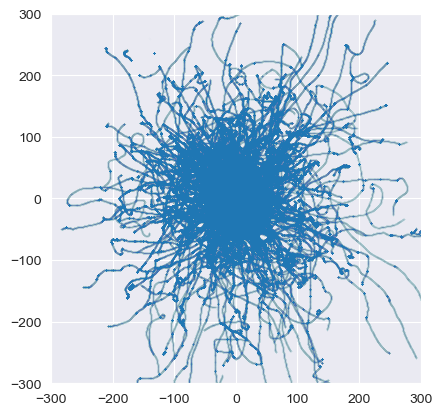

In [176]:
plt.scatter(df['X'], df['Y'], s=0.06, alpha=0.03)#, c=df['trial_id'], cmap='viridis')
plt.xlim(-300, 300)
plt.ylim(-300, 300)
plt.gca().set_aspect('equal')
plt.show()